<a href="https://colab.research.google.com/github/FelixBey/demo_fastai/blob/presentation/demo_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up Colab and Drive for Project

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd "drive/My Drive/PJS"

/content/drive/My Drive/PJS


In [0]:
from fastai.vision import *

##Download Images

With the help of the *fastai* library we scrape images from Google for each category and save them to a dedicated folder. Afterwards the dataset was manually 'cleaned' from wrongly downloaded images.

In [0]:
download_images('riemen.csv', dest='/content/drive/My Drive/PJS/keilriemen', max_pics=400)

In [0]:
download_images('zahn.csv', dest='/content/drive/My Drive/PJS/zahnrad', max_pics=400)

In [0]:
download_images('felge.csv', dest='/content/drive/My Drive/PJS/felge', max_pics=400)

In [0]:
download_images('nocken.csv', dest='/content/drive/My Drive/PJS/nockenwelle', max_pics=400)

In [0]:
download_images('kerze.csv', dest='/content/drive/My Drive/PJS/zündkerze', max_pics=400)

In [0]:
download_images('bremse.csv', dest='/content/drive/My Drive/PJS/bremsscheibe', max_pics=400)

## Load data

Load the images into a Databunch with the data block API and split them into training and validation set, do data augmentation and resize them.

In [0]:
data = (ImageList.from_folder(path='data')
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_folder()
        #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(), size=224)
        #Data augmentation? -> use tfms with a size of 224
        .databunch())
        #Finally -> use the defaults for conversion to databunch
       

Also, it would have been possible to do this with the 'shortcut'-function below:

In [0]:
# data = ImageDataBunch.from_folder(path='data',train=".", 
#                                   valid_pct=0.2,
#                                   ds_tfms=get_transforms(), 
#                                   size=224)

Which classes does the dataset include? How many images are in the training and validation set?

In [0]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['bremsscheibe',
  'felge',
  'keilriemen',
  'nockenwelle',
  'zahnrad',
  'zündkerze'],
 1224,
 305)

Let's take a look at the data with `show_batch`. Seems the data was loaded just fine!

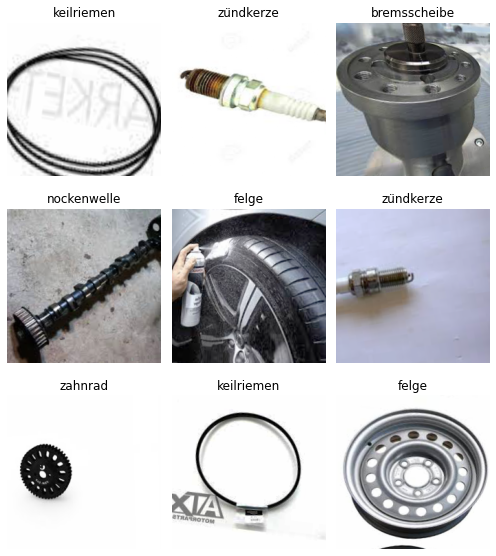

In [0]:
data.show_batch(rows=3, figsize=(7,8))

## Train model

First of all, we build the learner with a ResNet34 Architecture, the data of the Databunch and state `accuracy` as our metric of choice during training.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


We use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.20E-02


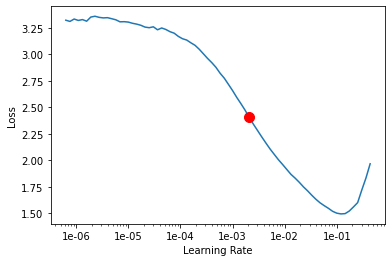

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

We now train the model for 6 epochs. In prior attempts, the model tended to have declining train loss but no declining valid loss after those epochs, which can indicate overfitting.

In [0]:
learn.fit_one_cycle(6, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.580829,0.348420,0.895082,01:56
1,0.812561,0.149162,0.947541,00:17
2,0.522807,0.150610,0.937705,00:18
3,0.356103,0.102293,0.954098,00:18
4,0.244132,0.113681,0.950820,00:18
5,0.181387,0.103360,0.954098,00:18


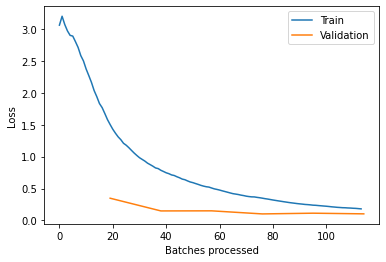

In [0]:
learn.recorder.plot_losses()

The model already achieves good accuracy. We save the weights of the model at this stage of training and proceed by unfreezing the remaining layers of the neural net and train for another four epochs after finding a proper learning rate.

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.096559,0.086757,0.960656,00:19
1,0.078976,0.107512,0.960656,00:19
2,0.063217,0.096509,0.967213,00:18
3,0.051178,0.081697,0.970492,00:19


In [0]:
learn.save('stage-2')

## Validation

We again save this stage and have a look at some of the predictions and the accuracy on the validation set.

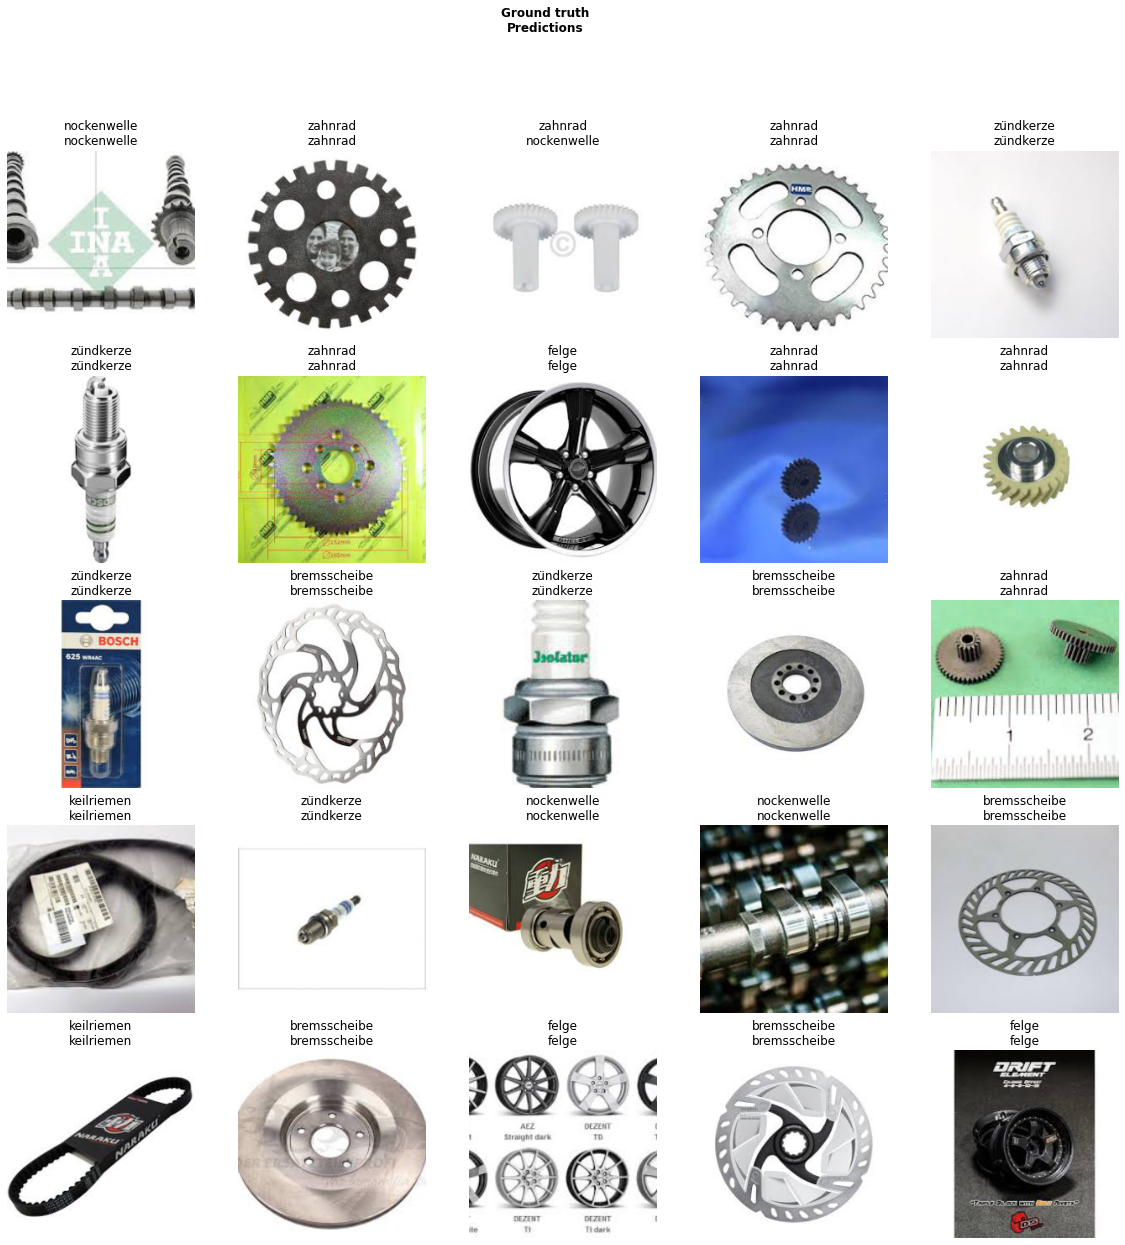

In [0]:
learn.show_results()

In [0]:
result = learn.validate()[1]
print("The accuracy on the validation set is", round(result.item(), 4))

The accuracy on the validation set is 0.9705


We now use the `ClassificationInterpretation` class to have a further look at what's going on.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

We can see below that some categories like 'felge' and 'nockenwelle' do very well while there have been some misclassifications with 'zahnrad'.

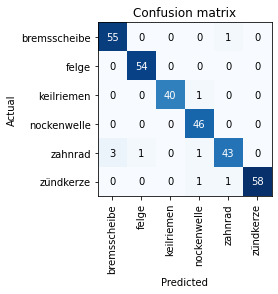

In [0]:
interp.plot_confusion_matrix()

Displaying the top losses can provide some explanation on why some misclassifications happened. The third and fourth picture show how similar in structure the 'zahnrad' and 'bremsscheibe' categories can be, which explains to a certain extend the mistakes made by the model.

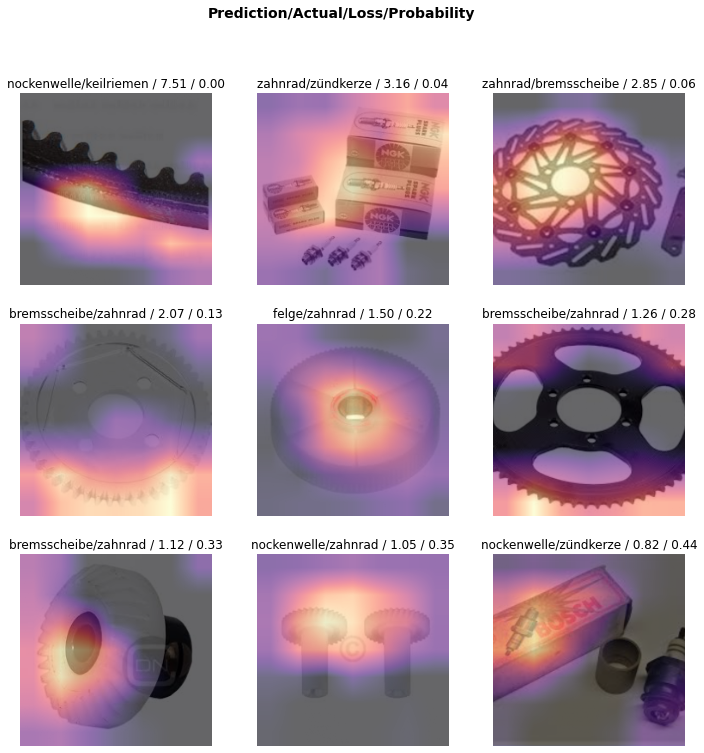

In [0]:
interp.plot_top_losses(9, heatmap=True, figsize=(12,12))

##Inference

We export the learner to a .pkl-file so it can be deployed to production in the future. Subsequently, we can load this exported file with `load_learner`.

In [0]:
learn.export()

In [0]:
learn = load_learner()

We add the previously held-out test set to do inference and check if our model does a good job on unseen data.

In [0]:
data.add_test(ImageList.from_folder('test'))
learn.data = data
data

With `get_preds` we get the predictions of our model for the test set. The second line of the cell below is necessary to extract the predicted classes, otherwise it will just give us the actual class of each test image, which would be 0 because they are unlabelled.

In [0]:
predictions, y = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)


Since the `get_preds` gives us the predictions as tensors, we change those results to the actual names of the predicted classes and save them in a list.

In [0]:
pred_classes=[]
for i in range(30):
  pred_classes.append(data.classes[labels[i]])
pred_classes

['keilriemen',
 'keilriemen',
 'keilriemen',
 'keilriemen',
 'keilriemen',
 'zahnrad',
 'zahnrad',
 'zahnrad',
 'zahnrad',
 'zahnrad',
 'felge',
 'felge',
 'felge',
 'felge',
 'felge',
 'nockenwelle',
 'nockenwelle',
 'nockenwelle',
 'nockenwelle',
 'nockenwelle',
 'bremsscheibe',
 'bremsscheibe',
 'bremsscheibe',
 'bremsscheibe',
 'bremsscheibe',
 'zündkerze',
 'zündkerze',
 'zündkerze',
 'zündkerze',
 'zündkerze']

We show the test images with the corresponding predicted classes. All of the images seem to be classified correctly by our model.

/usr/local/lib/python3.6/dist-packages/fastai/vision/image.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: fig,ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.6/dist-packages/fastai/vision/image.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: fig,ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.6/dist-packages/fastai/vision/image.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

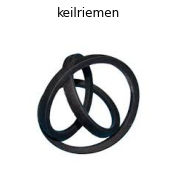

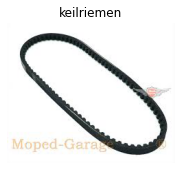

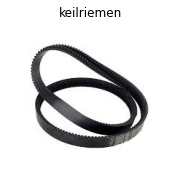

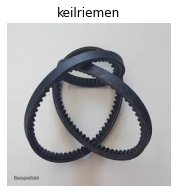

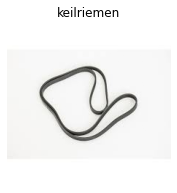

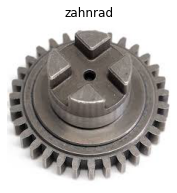

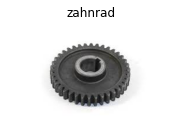

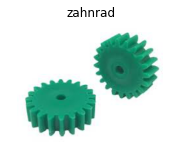

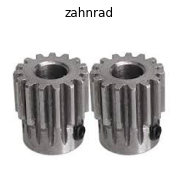

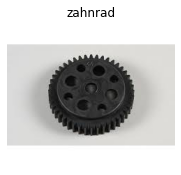

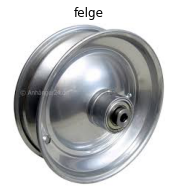

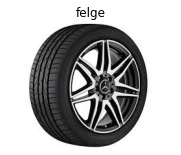

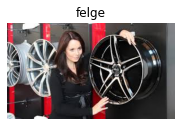

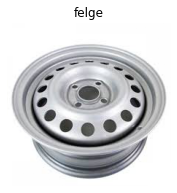

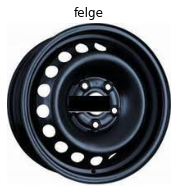

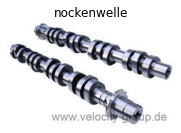

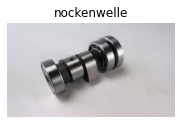

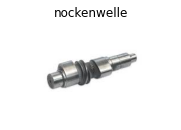

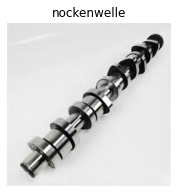

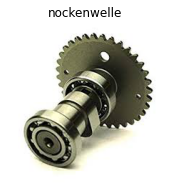

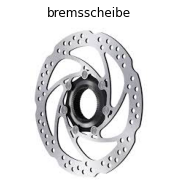

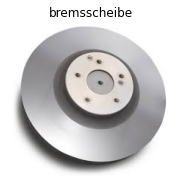

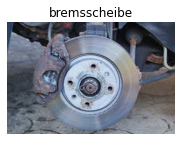

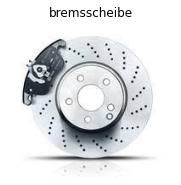

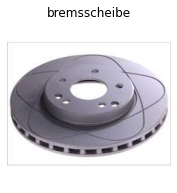

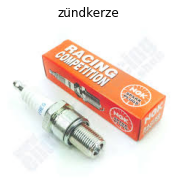

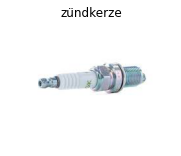

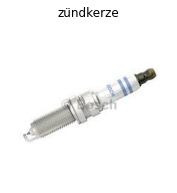

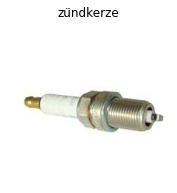

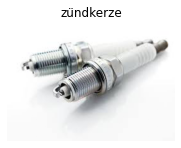

In [0]:
for i in range(30):
  img = show_image(data.test_ds.x[i])
  img.set_title(pred_classes[i])